In [24]:
"""Validates the adjoint gradient of a metalens in 3d."""

import meep as mp
import meep.adjoint as mpa
import numpy as np
import nlopt
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
from matplotlib import pyplot as plt

Air = mp.Medium(index=1.0)
SiN = mp.Medium(index=1.5)


resolution = 20 
Lpml = 0.5 
pml_layers = [mp.PML(thickness = Lpml, direction = mp.Z)]
Sourcespace = 0.5

design_region_width_x = 0.5
design_region_width_y = 0.5 
design_region_height = 0.5 

Sx = design_region_width_x
Sy = design_region_width_y
Sz = Lpml + design_region_height + Sourcespace + 1 + Lpml
cell_size = mp.Vector3(Sx, Sy, Sz)

wavelengths = np.array([0.5])
frequencies = 1/wavelengths
nf = len(frequencies) 

design_region_resolution = int(resolution)

fcen = 1 / 0.5
width = 0.1
fwidth = width * fcen

source_center = [0, 0, Sz / 2 - Lpml - Sourcespace / 2 ] 
source_size = mp.Vector3(Sx, Sy, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [mp.Source(src, component=mp.Ex, size=source_size, center=source_center,),]

Nx = int(round(design_region_resolution * design_region_width_x)) 
Ny = int(round(design_region_resolution * design_region_width_y)) 
Nz = int(round(design_region_resolution * design_region_height))

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny, Nz), Air, SiN, grid_type="U_MEAN",do_averaging=False)
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace - design_region_height/2),
        size=mp.Vector3(design_region_width_x, design_region_width_y, design_region_height),
    ),
)

geometry = [
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),
]

sim = mp.Simulation(
    cell_size=cell_size, 
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air, 
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

monitor_position_0, monitor_size_0 = mp.Vector3(-design_region_width_x/2, design_region_width_y/2, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 

FourierFields_0_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ex,yee_grid=True)


ob_list = [FourierFields_0_x]


def J(fields):
    return npa.mean(npa.abs(fields[:,1]) ** 2)

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-1,
)

     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)


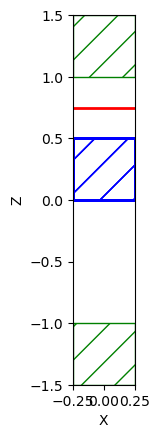

In [25]:
opt.plot2D(True,output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))

     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)


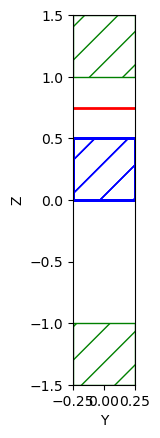

In [26]:
opt.plot2D(True,output_plane = mp.Volume(size = (0, np.inf, np.inf), center = (0,0,0)))

In [27]:
f0, dJ_du = opt()

Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.21729e-05 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 3 with resolution 20
     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0127962 s
-----------
run 0 finished at t = 50.425000000000004 (2017 timesteps)
Starting adjoint run...
run 1 finished at t = 50.050000000000004 (2002 timesteps)
Calculating gradient...


In [28]:
db = 1e-5
choose = 1000
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)

-----------
Initializing structure...
time for choose_chunkdivision = 2.31266e-05 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 3 with resolution 20
     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0118649 s
-----------
run 2 finished at t = 50.050000000000004 (2002 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 1.78814e-05 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 3 with resolution 20
     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0120559 s
-----------
run 3 finished at t = 50.050000000000004 (2002 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 1.81198e-05 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 3 with resolution 20
     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0

In [29]:
(m, b) = np.polyfit(np.squeeze(g_discrete), dJ_du[idx], 1)

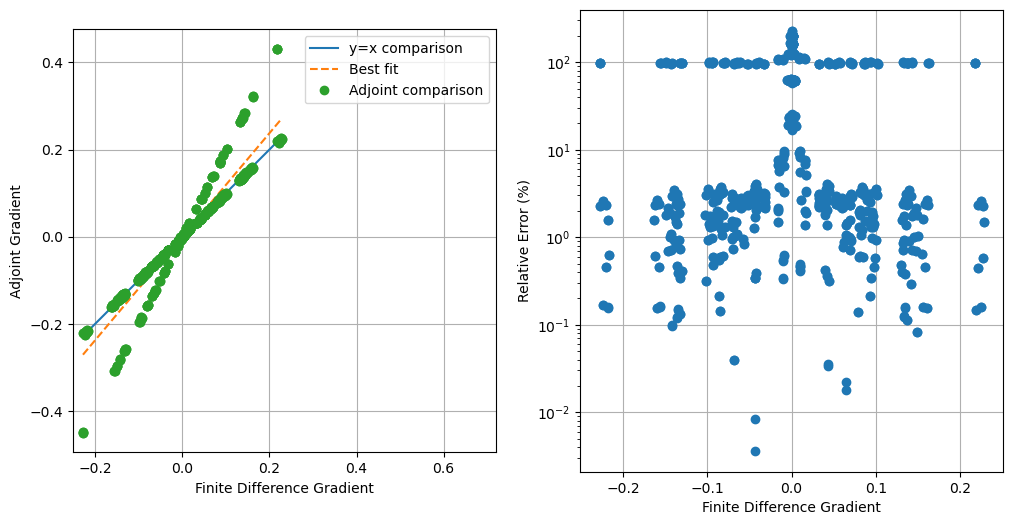

In [30]:
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
plt.plot(g_discrete, dJ_du[idx], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du[idx]))
    / np.abs(np.squeeze(g_discrete))
    * 100
)
plt.semilogy(g_discrete, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")
plt.show()

plt.savefig("graph.png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure
plt.show()

In [31]:
print(idx)

range(0, 1000)


In [40]:
print(np.min(dJ_du_0))

-0.03463743507594641


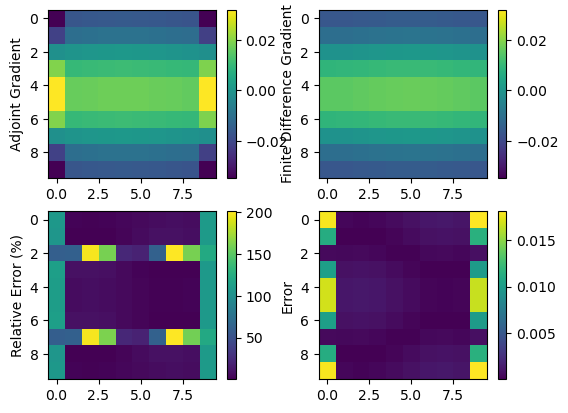

In [42]:

f=3

plt.subplot(2, 2, 1)
dJ_du_0 = dJ_du.reshape(Nx *Ny, Nz).transpose()[f]
plt.imshow(np.rot90(dJ_du_0.reshape(Nx, Ny)),)
plt.ylabel("Adjoint Gradient")
plt.clim(np.min(dJ_du_0), np.max(dJ_du_0))
plt.colorbar()


plt.subplot(2, 2, 2)
g_discrete_0 = np.squeeze(g_discrete).reshape(Nx *Ny, Nz).transpose()[f]
plt.imshow(np.rot90(g_discrete_0.reshape(Nx, Ny)),)
plt.ylabel("Finite Difference Gradient")
plt.clim(np.min(dJ_du_0), np.max(dJ_du_0))
plt.colorbar()



plt.subplot(2, 2, 3)
err_p=rel_err.reshape(Nx *Ny, Nz).transpose()[f]
plt.imshow(np.rot90(err_p.reshape(Nx, Ny)),)
plt.ylabel("Relative Error (%)")
plt.colorbar()


plt.subplot(2, 2, 4)
r_err = (
    np.abs(np.squeeze(g_discrete_0) - np.squeeze(dJ_du_0)))
plt.imshow(np.rot90(r_err.reshape(Nx, Ny)),)
plt.ylabel("Error")
plt.colorbar()

